# Quantum query algorithms

### Deutsch's algorithm implementation

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

First, we will define a quantum circuit that implements a query gate for one of the four functions $f_1$, $f_2$, $f_3$ and $f_4$ from one bit to one bit defined in the documentation. Implementing the query gates is not really a part of the algorithm itself, here we will show one way to prepare the input, in the form of a circuit implementation of a query gate.

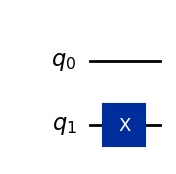

In [6]:
def deutsch_function(case: int):
    # This function generates a quantum circuit for one of the four functions from one bit to one bit.

    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

display(deutsch_function(4).draw(output="mpl"))

We now create the actual quantum circuit for the Deutsch algorithm, substituting the query gate with a quantum circuit implementation given as an argument. The lower qubit is set by a X gate into |1>

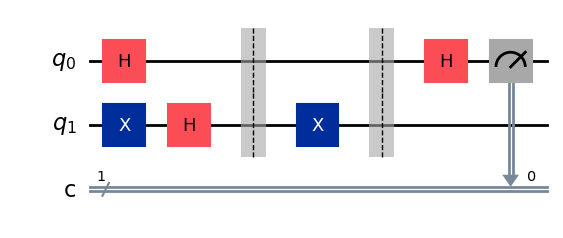

In [12]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in Deutch's algorithm

    n = function.num_qubits - 1
    qc = QuantumCircuit(n+1, n)

    qc.x(n)
    qc.h(range(n+1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

display(compile_circuit(deutsch_function(4)).draw(output="mpl"))

Now a function is created to run the circuit one time and output the appropiate result: "constant" or "balanced".

In [18]:
def deutsch_algorithm(function: QuantumCircuit):
    # Determine if a one-bit function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurement = result.get_memory()
    if measurement[0] == '0':
        return "constant"
    else:
        return "balanced"
    
f = deutsch_function(1)
display(deutsch_algorithm(f))

'constant'

### Deutsch-Josza algorithm - solving the Deutsch-Josza problem (implementation)

In [19]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

To implement the Deutsch-Jozsa algorithm in Qiskit, we'll start by defining a function dj_query that generates a quantum circuit implementing a query gate, for a randomly selected function satisfying the promise for the Deutsch-Jozsa problem. With a 50% chance, the function is constant, and with 50% change the function is balanced. For each of those two possibilities, the function is selected uniformly from the functions of that type. The argument is the number of input bits of the function.

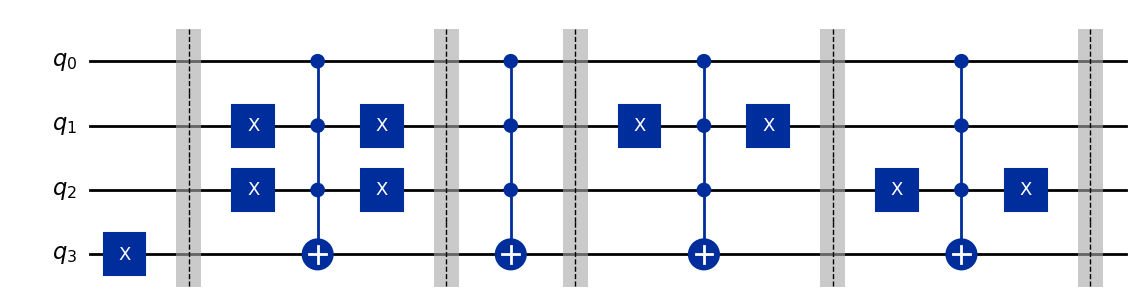

In [41]:
def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function satisfying the promise for the Deutsch-Jozsa problem.

    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

display(dj_query(3).draw(output="mpl"))

Next we define a function that creates the Deutsch-Jozsa circuit, taking a quantum circuit implementation of a query gate as an argument. Then finally, a function that runs the Deutsch-Jozsa circuit once is defined.

In [43]:
def compile_circuit_deutsch_josza_alg(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

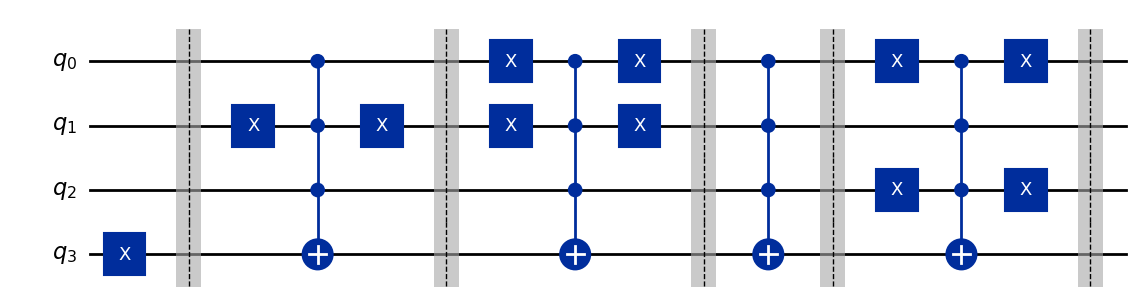

'balanced'

In [46]:
f = dj_query(3)
display(f.draw("mpl"))
display(dj_algorithm(f))

### Deutsch-Josza algorithm - solving the Bernstein-Vazirani problem (implementation)

First we'll define a function that implements a query gate for the Bernstein-Vazirani problem given any binary string s.

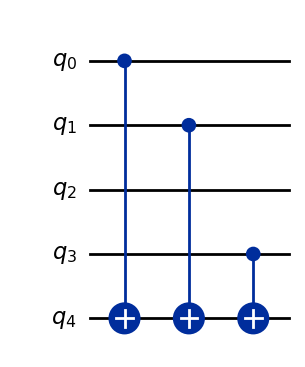

In [47]:
def bv_query(s):
    # Create a quantum circuit implementing a query gate for the Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(s)+1)
    for index, bit in enumerate(reversed(s)):
        if bit == '1':
            qc.cx(index, len(s))
    return qc
display(bv_query("1011").draw("mpl"))

Now we create a function that runs the Deutsch-Josza circuit on the function, using the compile_circuit_deutsch_josza_alg function defined previuosly.

In [50]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit_deutsch_josza_alg(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]
display(bv_algorithm(bv_query("1011")))

'1011'

### Simon's algorithm implementation

In [20]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

To implement this algorithm we will use the fact that we can convert unitary matrices into gates in Qiskit using the .unitary method. Specifically, we'll use this methodology to define a query gate for a randomly chosen function satisfying Simon's problem for a given string s.

In [21]:
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for te hidden string 's'

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutatio will effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function g(x) = min{x,x ^ s}, which is a very simple 
    # function that satisfies the promise. (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the promise for s.
    
    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1
    
    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

Next we'll define a function that runs the circuit in Simon's problem k times and reports the results.

In [22]:
def simon_measurements(problem: QuantumCircuit, k: int):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that implements f, 
    # gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

display(simon_measurements(simon_function("10011"),k=12))

['11101',
 '11001',
 '01000',
 '00100',
 '11010',
 '01111',
 '11010',
 '11010',
 '10010',
 '01000',
 '11101',
 '11110']

We installed the galois extension because it has a built-in function for computing the null space modulo 2, which allows us to do the required postprocessing.

In [60]:
def simon_algorithm(problem: QuantumCircuit):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement results. Replace +10 by +r for 
    # any nonnegative integer r depending on desired confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

display(simon_algorithm(simon_function("10011")))

Guess for hidden string s: 


'10011'

# Quantum Algorithmic foundations

### Factoring and GCDs

The factorint function from the SymPy symbolic mathematics package for Python solves the integer factorization problem for whatever input N we choose. There is a considerable time scaing for larger N.

In [1]:
import math
from sympy.ntheory import factorint
import galois

N = 12
display(factorint(N))

N = 3402823669209384634633740743176823109843098343
display(factorint(N))

{2: 2, 3: 1}

{3: 2, 74519450661011221: 1, 5073729280707932631243580787: 1}

For even larger values of N, things become impossibly difficult, at least as far as we know. For example, the RSA Factoring Challenge, which was run by RSA Laboratories from 1991 to 2007, offered a cash prize of $100,000 to factor the following number, which has 309 decimal digits (or 1024 bits when written in binary). The prize for this number was never collected and its prime factors remain unknown.

In [67]:
RSA1024 = 135066410865995223349603216278805969938881475605667027524485143851526510604859533833940287150571909441798207282164471551373680419703964191743046496589274256239341020864383202110372958725762358509643110564073501508187510676594629205563685529475213500852879416377328533906109750544334999811150056977236890927563
display(RSA1024)

135066410865995223349603216278805969938881475605667027524485143851526510604859533833940287150571909441798207282164471551373680419703964191743046496589274256239341020864383202110372958725762358509643110564073501508187510676594629205563685529475213500852879416377328533906109750544334999811150056977236890927563

We need not bother running factorint on RSA1024, it wouldn't finish within our lifetimes.

The fastest known algorithm for factoring large integers is known as the number field sieve. As an example of this algorithm's use, the RSA challenge number RSA250, which has 250 decimal digits (or 829 bits when written in binary), was factored using the number field sieve in 2020. The computation required thousands of CPU core-years, distributed across tens of thousands of machines around the world.

In [66]:
RSA250 = 2140324650240744961264423072839333563008614715144755017797754920881418023447140136643345519095804679610992851872470914587687396261921557363047454770520805119056493106687691590019759405693457452230589325976697471681738069364894699871578494975937497937

p = 64135289477071580278790190170577389084825014742943447208116859632024532344630238623598752668347708737661925585694639798853367
q = 33372027594978156556226010605355114227940760344767554666784520987023841729210037080257448673296881877565718986258036932062711

display(RSA250 == p * q)

True

The greatest common divisor of two numbers is the largest integer that evenly divides both of them.

This problem is easy to solve with a computer — it has roughly the same computational cost as multiplying the two input numbers together. The gcd function from the Python math module computes the greatest common divisor of numbers that are considerably larger than RSA1024 in the blink of an eye. (In fact, RSA1024 is the GCD of the two numbers in this example.)

In [3]:
N = 4636759690183918349682239573236686632636353319755818421393667064929987310592347460711767784882455889983961546491666129915628431549982893638464243493812487979530329460863532041588297885958272943021122033997933550246447236884738870576045537199814804920281890355275625050796526864093092006894744790739778376848205654332434378295899591539239698896074
M = 5056714874804877864225164843977749374751021379176083540426461360945653967249306494545888621353613218518084414930846655066495767441010526886803458300440345782982127522212209489410315422285463057656809702949608368597012967321172325810519806487247195259818074918082416290513738155834341957254558278151385588990304622183174568167973121179585331770773

display(math.gcd(N, M))

135066410865995223349603216278805969938881475605667027524485143851526510604859533833940287150571909441798207282164471551373680419703964191743046496589274256239341020864383202110372958725762358509643110564073501508187510676594629205563685529475213500852879416377328533906109750544334999811150056977236890927563

We can push it even further and compute GCDs for numbers with thousands of digits in no time.



In [4]:
display(math.gcd(N**200 + 1, M**100 + M**2))

113

Python's built-in pow function, which uses the power algorithm, solves this problem quickly for fairly large input numbers. It's a little bit slower than computing GCDs, but it's still fast.

In [5]:
K = 64135289477071580278790190170577389084825014742943447208116859632024532344630238623598752668347708737661925585694639798853367
N = 4636759690183918349682239573236686632636353319755818421393667064929987310592347460711767784882455889983961546491666129915628431549982893638464243493812487979530329460863532041588297885958272943021122033997933550246447236884738870576045537199814804920281890355275625050796526864093092006894744790739778376848205654332434378295899591539239698896074
M = 5056714874804877864225164843977749374751021379176083540426461360945653967249306494545888621353613218518084414930846655066495767441010526886803458300440345782982127522212209489410315422285463057656809702949608368597012967321172325810519806487247195259818074918082416290513738155834341957254558278151385588990304622183174568167973121179585331770773

display(pow(N, K**10 + 1, M**10 + 1))

5420808908959774060288987536719770456217318912094898225713892936909049029205875268391016773496273016272919329382669533127141405381618319955871147811133071683113976741106560564348611362839209748910974112799894385464900617664468329271717655067495341858822704829649579551724483155264208314048742469387847020407987537873027379036515942355206425576104942394452390040081069041858525217985044712018028991394635458870225358476099232040714610377672598679720015462702833934580459151626243131178465271884695260294198503010478207039551370657556801980546328939683389782893101937977023160027020824612118350981172299997784862364914426784395705304625946981620876565903630321426713564601636615003526450559450988257054265576673783996389684225946503950767764911765912500478971120407712043832726706539999202935732936820400534970855338294653369081634048804115320256182211145544094816107629124112742249226319353536843143250675559791743355892993051078488285292927178023438402583054839832109503781471596500072959107707020065

 For the post-processing step of Simon's algorithm, we need to compute the null space modulo 2 of an n×m matrix of binary values (so here the input length is nm bits in total). Still the processing takes only a few seconds.

In [8]:
GF = galois.GF(2)

N, n = 1000, 1000

A = GF.Random((N, n))
B = A.null_space()
print(B)

[[1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1
  0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1
  1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0
  1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0
  0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1
  0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0
  1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
  1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1
  1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0
  0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0
  1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1
  0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1
  0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1
  1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 

# Phase-estimation and factoring

Checking the spectral decomposition of Hadamard operations.

In [10]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from math import pi, cos, sin

psi1 = Statevector([cos(pi / 8), sin(pi / 8)])
psi2 = Statevector([cos(5 * pi / 8), sin(5 * pi / 8)])

# When given a Statevector input, the Operator function returns the outer
# product of that state vector with itself — or, in other words, the
# product of the vector times its conjugate transpose.

H = Operator(psi1) - Operator(psi2)
display(H.draw("latex"))

<IPython.core.display.Latex object>

### Low precision procedure: using phase kickback

For this implementation we'll use a phase gate for the unitary operation in the interest of simplicity — so the relevant eigenvector is the ∣1⟩ state.

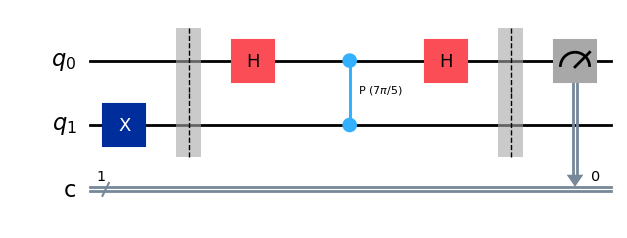

In [11]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi, cos, sin

theta = 0.7  # Can be changed to any value between 0 and 1
qc = QuantumCircuit(2, 1)

# Prepare the eigenvector, which is the |1> state
qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

# Draw the circuit
display(qc.draw(output="mpl"))

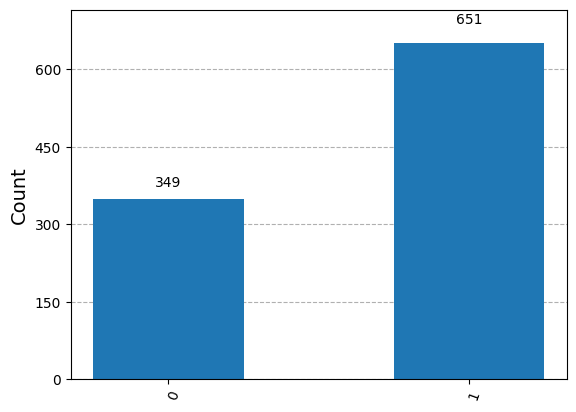

In [31]:
result = AerSimulator().run(qc, shots = 1000).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [16]:
print(f"cos(pi * {theta})**2 = {cos(pi * theta) ** 2:.4f}")
print(f"sin(pi * {theta})**2 = {sin(pi * theta) ** 2:.4f}")

cos(pi * 0.7)**2 = 0.3455
sin(pi * 0.7)**2 = 0.6545


### Low precision procedure: Two-qubit phase estimation

We combine "doubling the phase" and "phase kickback" methods. We'll use a phase gate with a chosen angle θ for the unitary operation and ∣1⟩ for the eigenvector.

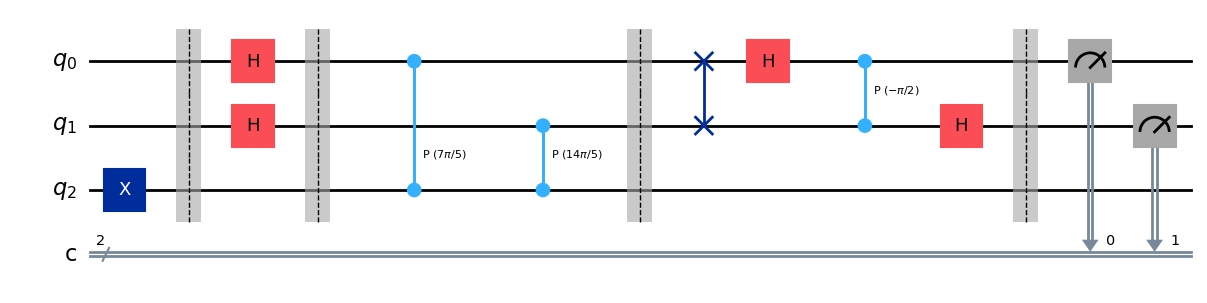

In [36]:
theta = 0.7
qc = QuantumCircuit(3, 2)

# Prepare the eigenvector
qc.x(2)
qc.barrier()

# The initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2 * pi * theta, 0, 2)
qc.cp(2 * pi * (2 * theta), 1, 2)
qc.barrier()

# An implementation of the inverse of the twp-qubit QFT
qc.swap(0, 1)
qc.h(0)
qc.cp(-pi / 2, 0, 1)
qc.h(1)
qc.barrier()

# And finally the measurements
qc.measure([0, 1], [0, 1])
display(qc.draw(output="mpl"))

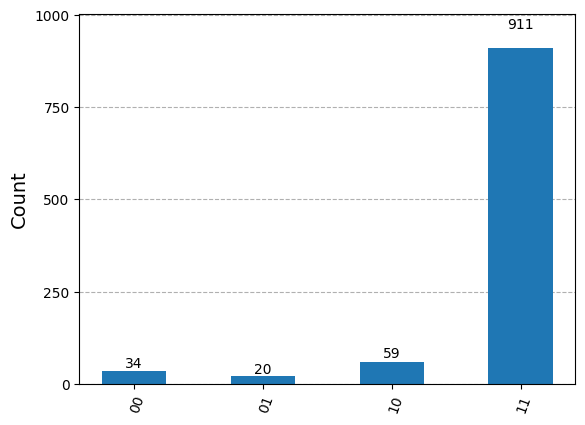

In [43]:
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

### Quantum Fourier Transform

A circuit implementation of the QFT on any number of qubits can be obtained from a library. Note that for three or more qubits the circuit will differ slightly from the general description above because it incorporates some minor optimizations, including pushing the swap gates to the end of the circuit and adjusting the controlled-phase gates accordingly.

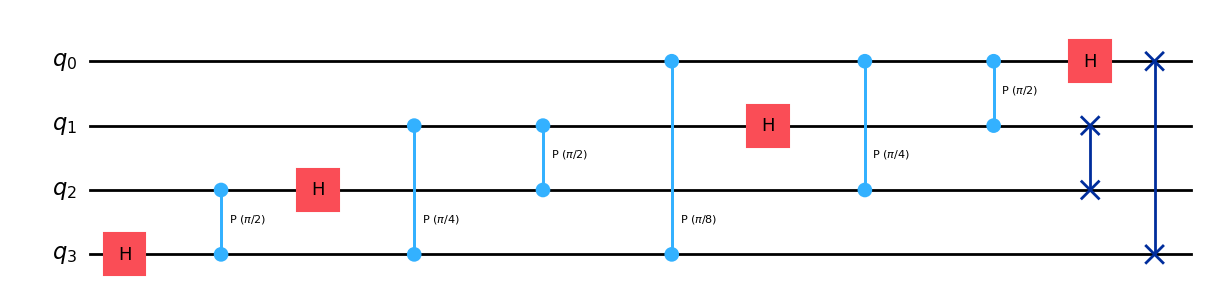

In [50]:
from qiskit.circuit.library import QFT
display(QFT(4).decompose().draw("mpl"))

### General phase estimation procedure

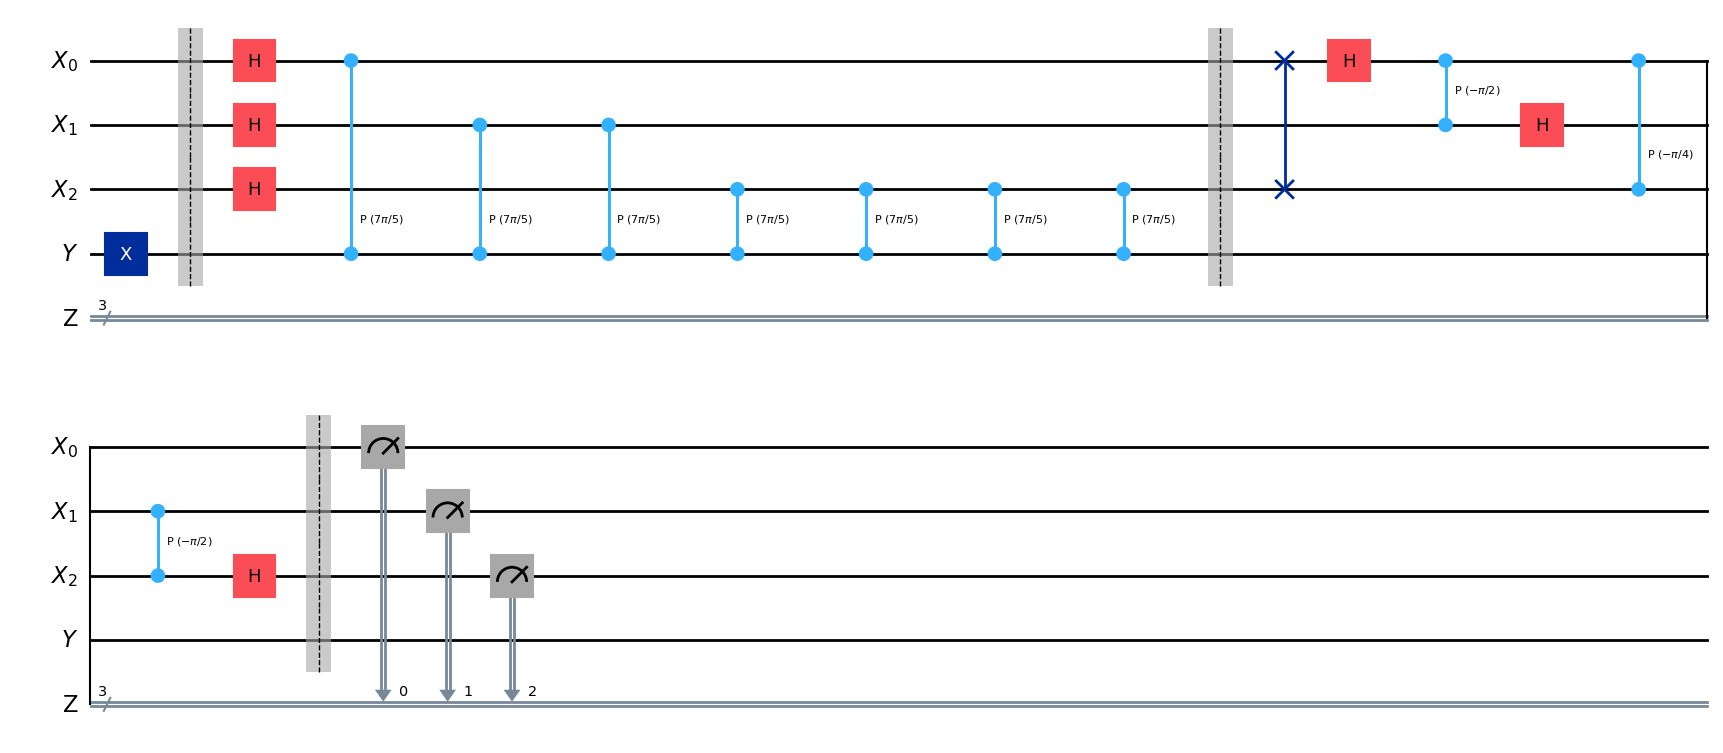

In [52]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

theta = 0.7
m = 3 # Number of control qubits

control = QuantumRegister(m, name="X")
target = QuantumRegister(1, name="Y")
output = ClassicalRegister(m, name="Z")
qc = QuantumCircuit(control, target, output)

# Prepare the eigenvector
qc.x(target)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target)
qc.barrier()

# Perform the inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True).decompose(),
    inplace=True
)
qc.barrier()

# Measure everythig
qc.measure(range(m), range(m))

display(qc.draw("mpl"))

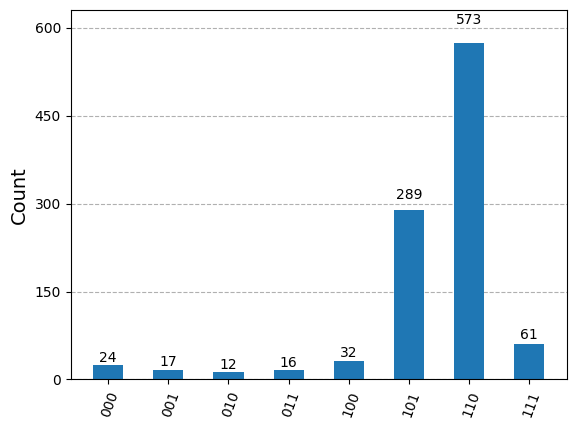

In [70]:
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

The most-frequently appearing result determines our guess for θ.

In [71]:
most_probable = int(max(statistics, key=statistics.get),2)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 6
Estimated theta: 0.75


### Shor's algorithm

We'll conclude the lesson by implementing Shor's algorithm in Qiskit — with a caveat to be explained first.

To factor a positive integer N, Shor's algorithm requires an implementation of the operation $M_b$ for various elements b∈$Z_N^*$. This can be done (using workspace qubits) as described above, based on the methodology explained in the Quantum algorithmic foundations lessons. But actually constructing quantum circuits for these operations is rather laborious and won't be done here. (It would make for an interesting project, though.) Instead, what we'll do is to create explicit matrix representations of these operations and then use Qiskit's UnitaryGate function, which converts the matrix into a custom gate that can be used in a quantum circuit.

We can then ask the Qiskit transpiler to convert these custom gates into an actual quantum circuit. This is terribly inefficient — it requires time exponential in n and results in very large circuits in general — but this is the price we're paying to avoid the work of having to explicitly construct efficient modular multiplication circuits. So, this doesn't represent a true implementation of Shor's algorithm in this regard, but it does offer a reasonably general demonstration for the purposes of the lesson while keeping the coding simple (and doing something fun with Qiskit).

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import numpy as np
from math import gcd, floor, log
from fractions import Fraction
import random

The first step is to define a function that creates the gate $M_b$ for a given element b∈$Z_N^∗$.

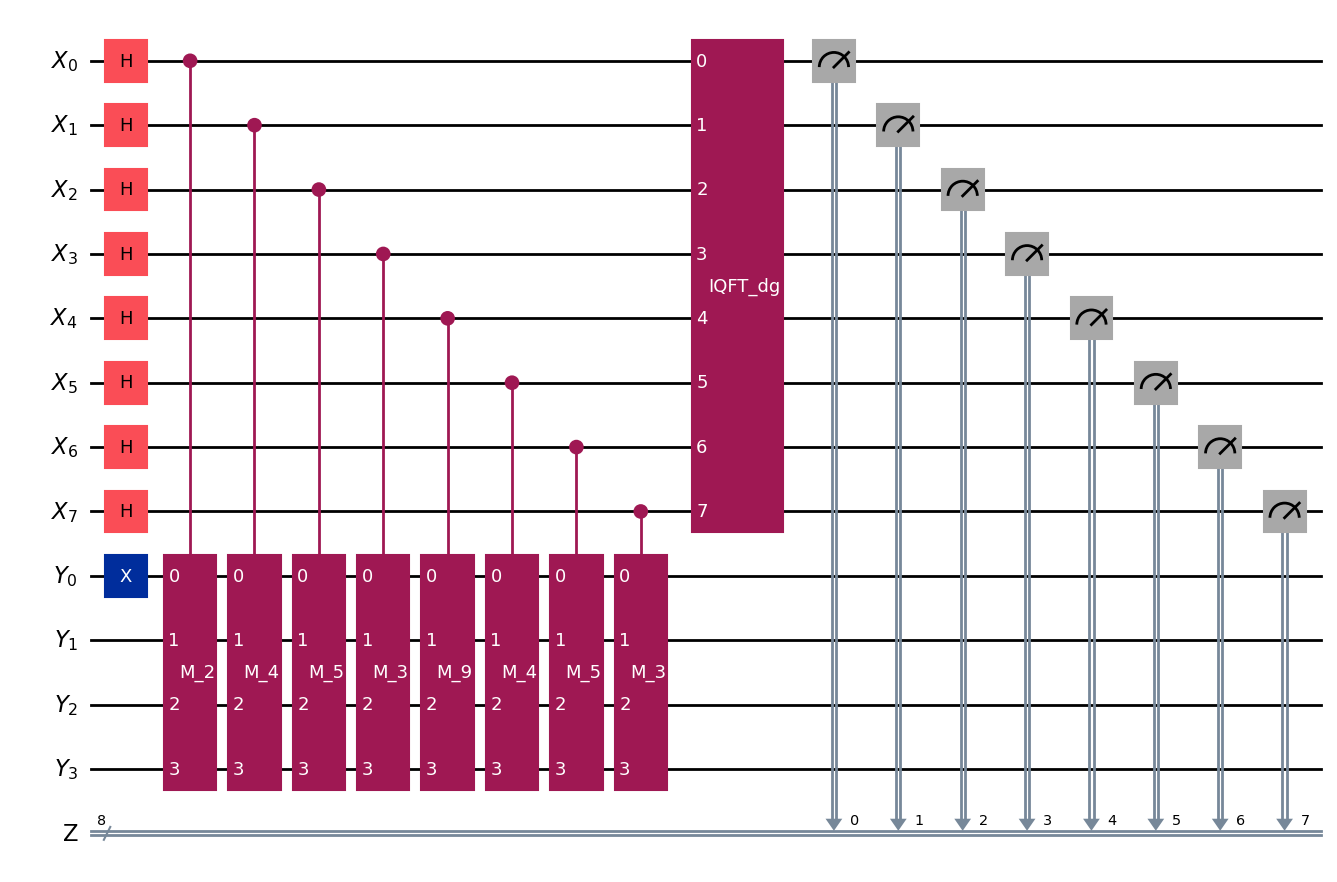

In [4]:
def mod_mult_gate(b,N):
    if gcd(b,N)>1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        U = np.full((2**n,2**n),0)
        for x in range(N): U[b*x % N][x] = 1
        for x in range(N,2**n): U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G
    
# Next we'll define a function that builds the quantum circuit associated with order-finding for a given element a

def order_finding_circuit(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n

        control = QuantumRegister(m, name = "X")
        target = QuantumRegister(n, name = "Y")
        output = ClassicalRegister(m, name = "Z")
        circuit = QuantumCircuit(control, target, output)

        # Initialize the target register to the state |1>
        circuit.x(m)

        # Add the Hadamard gates and controlled versions of the
        # multiplication gates
        for k, qubit in enumerate(control):
            circuit.h(k)
            b = pow(a,2**k,N)
            circuit.compose(
                mod_mult_gate(b,N).control(),
                qubits = [qubit] + list(target),
                inplace=True)

        # Apply the inverse QFT to the control register
        circuit.compose(
            QFT(m, inverse=True),
            qubits=control,
            inplace=True)

        # Measure the control register
        circuit.measure(control, output)

        return circuit

order_finding_circuit(2,11).draw(output = "mpl")

We can now define a function find_order that runs the order-finding circuit and determines the order of a given element a∈$Z_N^∗$ using phase estimation together with the continued fraction algorithm. This function can take a while to run, owing in part to the transpilation of the order-finding circuit that includes our custom modular multiplication gates. We're asking the transpiler to do what we decided was too laborious — and without using workspace qubits!

In [5]:
def find_order(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n
        circuit = order_finding_circuit(a,N)
        transpiled_circuit = transpile(circuit,AerSimulator())

        while True:
            result = AerSimulator().run(
                transpiled_circuit,
                shots=1,
                memory=True).result()
            y = int(result.get_memory()[0],2)
            r = Fraction(y/2**m).limit_denominator(N).denominator
            if pow(a,r,N)==1: break
        return r

In [ ]:
N = 231
a = 13
print(f"The order of {a} modulo {N} is {find_order(a,N)}.")

In [ ]:
N = 39

FACTOR_FOUND = False

# First we'll check to see if N is even or a nontrivial power.
# Order finding won't help for factoring a *prime* power, but
# we can easily find a nontrivial factor of *any* nontrivial
# power, whether prime or not.

if N % 2 == 0:
    print("Even number")
    d = 2
    FACTOR_FOUND = True
else:
    for k in range(2,round(log(N,2))+1):
        d = int(round(N ** (1/k)))
        if d**k == N:
            FACTOR_FOUND = True
            print("Number is a power")
            break

# Now we'll iterate until a nontrivial factor of N is found.

while not FACTOR_FOUND:
    a = random.randint(2,N-1)
    d = gcd(a,N)
    if d>1:
        FACTOR_FOUND = True
        print(f"Lucky guess of {a} modulo {N}")
    else:
        r = find_order(a,N)
        print(f"The order of {a} modulo {N} is {r}")
        if r % 2 == 0:
            x = pow(a,r//2,N) - 1
            d = gcd(x,N)
            if d>1: FACTOR_FOUND = True

print(f"Factor found: {d}")

# Grover's algorithm

### Chosing the number of iterations

Given the Grover's algorithm and the action of G on |u>, we need to find a proper value of how many times G is applied to the vector. 

Scatter plot


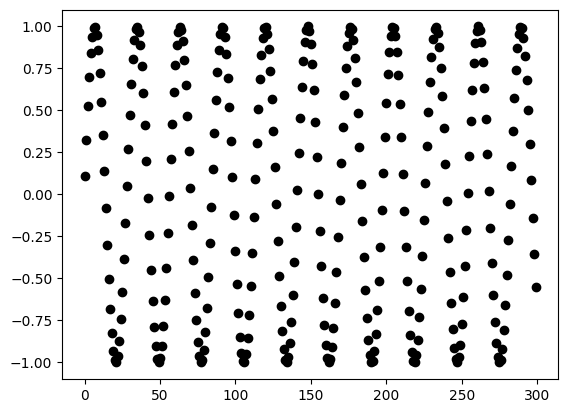

Linear interpolation


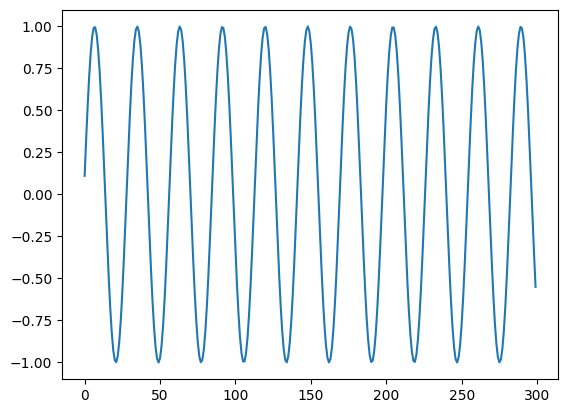

In [10]:
import numpy as np
import math
from matplotlib import pyplot as plt

theta = 1 / 9       # Angle in radias (can be changed as desired)
t = np.arange(0, 300, 1)
y = np.sin((2 * t + 1) * theta)

print("Scatter plot")
plt.plot(t, y, "o", color="black")
plt.show()

print("Linear interpolation")
plt.plot(t, y)
plt.show()

### Unique search

In [11]:
for n in range(1, 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(1 / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, p))

2	 0.5000000000
4	 1.0000000000
8	 0.9453125000
16	 0.9613189697
32	 0.9991823155
64	 0.9965856808
128	 0.9956198657
256	 0.9999470421
512	 0.9994480262
1024	 0.9994612447
2048	 0.9999968478
4096	 0.9999453461
8192	 0.9999157752
16384	 0.9999997811
32768	 0.9999868295
65536	 0.9999882596
131072	 0.9999992587
262144	 0.9999978382
524288	 0.9999997279


### Multiple solutions

In [12]:
# Starting the loop with n=2 because we can't have 4 solutions
# when n=1.

for n in range(2, 20):
    N = 2**n
    wrong_theta = np.arcsin(np.sqrt(1 / N))
    correct_theta = np.arcsin(np.sqrt(4 / N))
    t = math.floor(np.pi / (4 * wrong_theta))
    p = np.sin((2 * t + 1) * correct_theta) ** 2
    print("%d\t %12.10f" % (N, p))

4	 1.0000000000
8	 0.5000000000
16	 0.2500000000
32	 0.0122070313
64	 0.0203807689
128	 0.0144530758
256	 0.0000705058
512	 0.0019310741
1024	 0.0023009083
2048	 0.0000077506
4096	 0.0002301502
8192	 0.0003439882
16384	 0.0000007053
32768	 0.0000533810
65536	 0.0000472907
131072	 0.0000030066
262144	 0.0000086824
524288	 0.0000010820


In [13]:
s = 7  # Number of solutions. This can be any positive integer.

# The loop starts with the smallest value of n that allows s solutions.
for n in range(math.ceil(math.log2(s)), math.ceil(math.log2(s)) + 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(s / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, np.sin((2 * t + 1) * theta) ** 2))

8	 0.8750000000
16	 0.6835937500
32	 0.9877929688
64	 0.9869401455
128	 0.9933758959
256	 0.9942813445
512	 0.9977678832
1024	 0.9999963373
2048	 0.9999257666
4096	 0.9983374778
8192	 0.9995465664
16384	 0.9995822234
32768	 0.9999531497
65536	 0.9998961946
131072	 0.9999998224
262144	 0.9999745784
524288	 0.9999894829
1048576	 0.9999939313
2097152	 0.9999979874
4194304	 0.9999986243


### Full implementation (Tutorial of Grover's algorithm) - separate notebook